In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        if(msg_field.startswith("'cTrainingError")):
            msg_field = " ".join(fields[11:-1])
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,21
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,32
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,21


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,21,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,32,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,21,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'monetdb'," "'mssql'," "'mysql'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (16621, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'monetdb', BernoulliNB 18 16
MODEL_DATASETS_MISSING 'monetdb', BernoulliNB_pipe 18 16
MODEL_DATASETS_MISSING 'monetdb', GaussianNB 18 15
MODEL_DATASETS_MISSING 'monetdb', GaussianNB_pipe 18 16
MODEL_DATASETS_MISSING 'monetdb', GradientBoostingClassifier 18 16
MODEL_DATASETS_MISSING 'monetdb', GradientBoostingClassifier_pipe 18 16
MODEL_DATASETS_MISSING 'monetdb', LGBMClassifier 18 15
MODEL_DATASETS_MISSING 'monetdb', LGBMClassifier_pipe 18 16
MODEL_DATASETS_MISSING 'monetdb', MLPClassifier 18 15
MODEL_DATASETS_MISSING 'monetdb', MLPClassifier_pipe 18 16
MODEL_DATASETS_MISSING 'monetdb', MultinomialNB 18 15
MODEL_DATASETS_MISSING 'monetdb', MultinomialNB_pipe 18 16
MODEL_DATASETS_MISSING 'monetdb', X

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,BernoulliNB,"'DS_BENCH_N_200_22_10_D28EF166',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
1,BernoulliNB,"'DS_BENCH_N_200_22_2_C38ADB8B',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
2,BernoulliNB,"'DS_BENCH_N_200_22_4_9802FBBD',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
3,BernoulliNB,"'DS_BENCH_N_200_7_10_C3DE2F26',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
4,BernoulliNB,"'DS_BENCH_N_200_7_2_102297A5',","'monetdb',",no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(16902, 8)

In [19]:
df.est_dialect.value_counts()

'mysql',       1878
'firebird',    1878
'pgsql',       1878
'oracle',      1878
'db2',         1878
'mssql',       1878
'sqltm',       1878
'monetdb',     1878
'teradata',    1878
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                     267
'monetdb',  TIMEOUT                                                       253
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   81
            'DatabaseError:(teradata.api.DatabaseError)                    50
'db2',      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'teradata', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'sqltm',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'pgsql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'oracle',   "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'mssql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'monetdb',  "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'mysql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'firebird', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     36
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   33
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   24
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   23
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   23
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   21
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   21
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   21
'teradata', TIMEOUT                                                        18
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   16
            "DatabaseError:(fdb.fbcore.DatabaseError)                      15
'oracle',   TIMEOUT                                                        10
'sqltm',    ) too many columns in result se                                 4
'teradata', "DatabaseError:(teradata.api.DatabaseError)                     4
'db2',      : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
'pgsql',    ) target lists can have at most 1664 entrie                     4
'sqltm',    ) too many terms in compound SELEC                              4
'monetdb',  'DBAPIError:(builtins.BrokenPipeError)                          3
'mysql',    1436, "Thread stack overrun:  1237888 bytes use...              2
'db2',      'InternalError:(ibm_db_dbi.InternalError)                       2
            : Statement Execute Failed: [IBM][CLI Driver][D...              2
'pgsql',    ) stack depth limit exceededHINT:  Increase the...              2
'mssql',    8631, b'Internal error: Server stack limit has ...              2
'sqltm',    ) Expression tree is too large (maximum depth 1000              2
'mssql',    'cTrainingError:ValueError:`min_samples` may no...              1
'firebird', 'cTrainingError:ValueError:`min_samples` may no...              1
'sqltm',    'cTrainingError:ValueError:`min_samples` may no...              1
'pgsql',    'cTrainingError:ValueError:`min_samples` may no...              1
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              1
            'cTrainingError:ValueError:`min_samples` may no...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'oracle',   'cTrainingError:ValueError:`min_samples` may no...              1
'monetdb',  'cTrainingError:ValueError:`min_samples` may no...              1
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'mysql',    'cTrainingError:ValueError:`min_samples` may no...              1
'teradata', 'cTrainingError:ValueError:`min_samples` may no...              1

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,15654
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",324
TIMEOUT,281
'DatabaseError:(fdb.fbcore.DatabaseError),267
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",263
'DatabaseError:(teradata.api.DatabaseError),50
"""DatabaseError:(fdb.fbcore.DatabaseError)",15
"'cTrainingError:ValueError:`min_samples` may not be larger than number of samples ``X.shape[0]``.'),",9
) too many terms in compound SELEC,4
) target lists can have at most 1664 entrie,4


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
lComparisonErrorMessage = '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS'
real_errors = df[df.error_message == lComparisonErrorMessage]
real_errors.Model.value_counts()

DummyClassifier_pipe               54
DummyClassifier                    54
ExtraTreesClassifier_pipe          29
FastICA                            16
AdaBoostClassifier_pipe            14
LinearDiscriminantAnalysis_pipe    14
FactorAnalysis                     12
ExtraTreesClassifier               10
XGBRegressor                        9
MultinomialNB                       7
MultinomialNB_pipe                  7
AdaBoostClassifier                  6
BaggingClassifier                   5
QuantileTransformer                 4
LGBMClassifier_pipe                 4
BaggingClassifier_pipe              4
RandomForestClassifier              4
RandomForestClassifier_pipe         3
EllipticEnvelope                    2
CalibratedClassifierCV_pipe         1
ExtraTreesRegressor_pipe            1
IsolationForest                     1
IsolationForest_pipe                1
CalibratedClassifierCV              1
Name: Model, dtype: int64

In [27]:
lNotImplementedMessage = '"Exception:CODE_GENERATION_NOT_IMPLEMENTED'
not_impl_errors = df[df.error_message == lNotImplementedMessage]
not_impl_errors.Model.value_counts()


SparsePCA                    108
MiniBatchSparsePCA           108
NMF                           54
LatentDirichletAllocation     54
Name: Model, dtype: int64

In [28]:
# database related errors
def is_other_error(df1):
    return df1.error_message.apply(lambda x : not x in ['SUCCESS', lComparisonErrorMessage, lNotImplementedMessage])

# other_errors = df.error_message.apply(lambda x : 1 if is_other_error(x)  else 0)
other_errors = df[is_other_error(df)]
other_errors.Model.value_counts()


NuSVC                               31
GaussianNB                          30
SVC                                 30
LGBMClassifier                      26
NuSVC_pipe                          25
SVC_pipe                            25
LGBMClassifier_pipe                 25
GradientBoostingClassifier_pipe     24
XGBClassifier_pipe                  24
GradientBoostingClassifier          24
MLPClassifier_pipe                  23
GaussianNB_pipe                     23
BernoulliNB_pipe                    23
BernoulliNB                         23
MultinomialNB_pipe                  22
MultinomialNB                       22
XGBClassifier                       21
PolynomialFeatures                  21
MLPClassifier                       21
AdaBoostClassifier_pipe             17
KernelPCA                           16
QuantileTransformer                 16
AdaBoostClassifier                  16
EllipticEnvelope                    15
RANSACRegressor                      9
CalibratedClassifierCV_pi

In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,21,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,7,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,32,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,21,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[df['error_message'] != lNotImplementedMessage]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,21,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,7,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,11,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,32,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,21,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                            \
dialect                         db2 firebird monetdb mssql mysql oracle pgsql   
model_category                                                                  
lightgbm.sklearn                 48       48      48    48    48     48    48   
sklearn.calibration              36       36      36    36    36     36    36   
sklearn.covariance               12       12      12    12    12     12    12   
sklearn.decomposition            72       72      72    72    72     72    72   
sklearn.discriminant_analysis    36       36      36    36    36     36    36   
sklearn.ensemble                252      252     252   252   252    252   252   
sklearn.feature_selection       108      108     108   108   108    108   108   
sklearn.kernel_ridge             12       12      12    12    12     12    12   
sklearn.linear_model            492      492     492   492   492    492   492   
sklearn.multiclass               72       72      72    72    72     72    72   
sklearn.naive_bayes             108      108     108   108   108    108   108   
sklearn.neural_network           48       48      48    48    48     48    48   
sklearn.pipeline                 48       48      48    48    48     48    48   
sklearn.preprocessing           150      150     150   150   150    150   150   
sklearn.svm                     156      156     156   156   156    156   156   
sklearn.tree                     96       96      96    96    96     96    96   
xgboost.sklearn                  48       48      48    48    48     48    48   
All                            1794     1794    1794  1794  1794   1794  1794   

                                                     
dialect                       sqltm teradata    All  
model_category                                       
lightgbm.sklearn                 48       48    432  
sklearn.calibration              36       36    324  
sklearn.covariance               12       12    108  
sklearn.decomposition            72       72    648  
sklearn.discriminant_analysis    36       36    324  
sklearn.ensemble                252      252   2268  
sklearn.feature_selection       108      108    972  
sklearn.kernel_ridge             12       12    108  
sklearn.linear_model            492      492   4428  
sklearn.multiclass               72       72    648  
sklearn.naive_bayes             108      108    972  
sklearn.neural_network           48       48    432  
sklearn.pipeline                 48       48    432  
sklearn.preprocessing           150      150   1350  
sklearn.svm                     156      156   1404  
sklearn.tree                     96       96    864  
xgboost.sklearn                  48       48    432  
All                            1794     1794  16146

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird   monetdb     mssql   
model_category                                                          
lightgbm.sklearn               0.020833  0.333333  0.666667  0.000000   
sklearn.calibration            0.000000  0.333333  0.000000  0.000000   
sklearn.covariance             0.166667  0.166667  0.250000  0.166667   
sklearn.decomposition          0.027778  0.194444  0.194444  0.027778   
sklearn.discriminant_analysis  0.138889  0.083333  0.055556  0.027778   
sklearn.ensemble               0.011905  0.226190  0.138889  0.011905   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.750000  0.000000  0.000000   
sklearn.linear_model           0.002033  0.010163  0.002033  0.002033   
sklearn.multiclass             0.000000  0.166667  0.000000  0.000000   
sklearn.naive_bayes            0.037037  0.351852  0.888889  0.018519   
sklearn.neural_network         0.000000  0.250000  0.645833  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.026667  0.080000  0.006667  0.000000   
sklearn.svm                    0.006410  0.512821  0.198718  0.000000   
sklearn.tree                   0.000000  0.000000  0.000000  0.000000   
xgboost.sklearn                0.020833  0.312500  0.666667  0.020833   
All                            0.013378  0.159978  0.154961  0.006689   

                                                                       \
dialect                           mysql    oracle     pgsql     sqltm   
model_category                                                          
lightgbm.sklearn               0.020833  0.020833  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.083333  0.166667  0.166667   
sklearn.decomposition          0.027778  0.027778  0.027778  0.027778   
sklearn.discriminant_analysis  0.055556  0.055556  0.027778  0.027778   
sklearn.ensemble               0.011905  0.011905  0.011905  0.011905   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.002033  0.002033  0.002033  0.002033   
sklearn.multiclass             0.000000  0.000000  0.000000  0.000000   
sklearn.naive_bayes            0.018519  0.018519  0.018519  0.018519   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.026667  0.053333   
sklearn.svm                    0.000000  0.064103  0.000000  0.000000   
sklearn.tree                   0.000000  0.000000  0.000000  0.000000   
xgboost.sklearn                0.020833  0.020833  0.020833  0.020833   
All                            0.007804  0.012821  0.008919  0.011148   

                                                   
dialect                        teradata       All  
model_category                                     
lightgbm.sklearn               0.145833  0.134259  
sklearn.calibration            0.083333  0.046296  
sklearn.covariance             0.166667  0.166667  
sklearn.decomposition          0.111111  0.074074  
sklearn.discriminant_analysis  0.083333  0.061728  
sklearn.ensemble               0.261905  0.077601  
sklearn.feature_selection      0.000000  0.000000  
sklearn.kernel_ridge           0.083333  0.092593  
sklearn.linear_model           0.016260  0.004517  
sklearn.multiclass             0.027778  0.021605  
sklearn.naive_bayes            0.083333  0.161523  
sklearn.neural_network         0.020833  0.101852  
sklearn.pipeline               0.020833  0.002315  
sklearn.preprocessing          0.080000  0.030370  
sklearn.svm                    0.089744  0.096866  
sklearn.tree                   

In [38]:
df.to_csv('report_extensive_tests.csv')

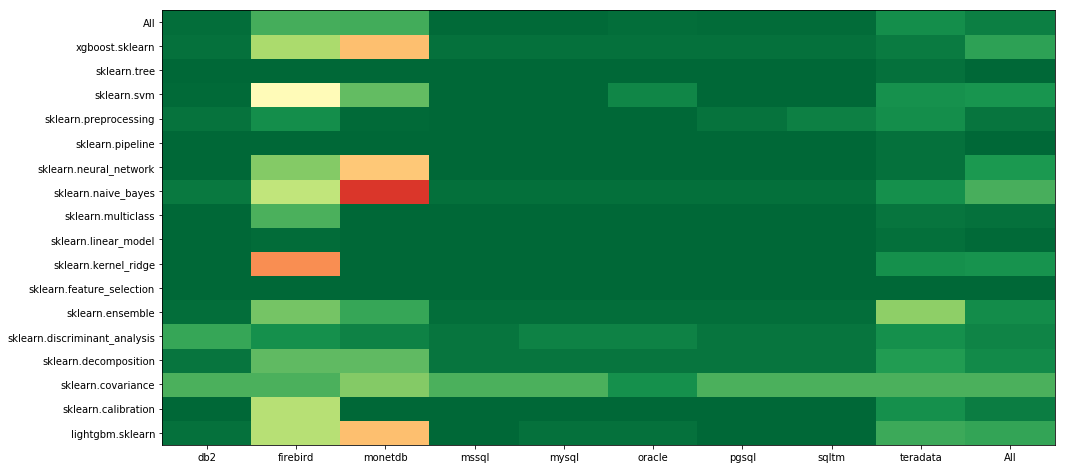

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', SUCCESS                                                  32
            'DatabaseError:(fdb.fbcore.DatabaseError)                16
'monetdb',  TIMEOUT                                                  31
            SUCCESS                                                  16
            'DBAPIError:(builtins.BrokenPipeError)                    1
'mssql',    SUCCESS                                                  48
'mysql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'oracle',   SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  48
'teradata', SUCCESS                                                  41
            'DatabaseError:(teradata.api.DatabaseError)               6
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1

mean                                                \
dialect                   db2  firebird   monetdb mssql     mysql    oracle   
Model                                                                         
LGBMClassifier       0.000000  0.388889  0.888889   0.0  0.000000  0.000000   
LGBMClassifier_pipe  0.055556  0.388889  0.888889   0.0  0.055556  0.055556   
LGBMRegressor        0.000000  0.166667  0.000000   0.0  0.000000  0.000000   
LGBMRegressor_pipe   0.000000  0.166667  0.000000   0.0  0.000000  0.000000   
All                  0.020833  0.333333  0.666667   0.0  0.020833  0.020833   

                                                     
dialect             pgsql sqltm  teradata       All  
Model                                                
LGBMClassifier        0.0   0.0  0.166667  0.160494  
LGBMClassifier_pipe   0.0   0.0  0.166667  0.179012  
LGBMRegressor         0.0   0.0  0.000000  0.018519  
LGBMRegressor_pipe    0.0   0.0  0.166667  0.037037  
All                   0.0   0.0  0.145833  0.134259

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  36
'firebird', SUCCESS                                                  24
            'DatabaseError:(fdb.fbcore.DatabaseError)                12
'monetdb',  SUCCESS                                                  36
'mssql',    SUCCESS                                                  36
'mysql',    SUCCESS                                                  36
'oracle',   SUCCESS                                                  36
'pgsql',    SUCCESS                                                  36
'sqltm',    SUCCESS                                                  36
'teradata', SUCCESS                                                  33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                             \
dialect                      db2  firebird monetdb mssql mysql oracle pgsql   
Model                                                                         
CalibratedClassifierCV       0.0  0.333333     0.0   0.0   0.0    0.0   0.0   
CalibratedClassifierCV_pipe  0.0  0.333333     0.0   0.0   0.0    0.0   0.0   
All                          0.0  0.333333     0.0   0.0   0.0    0.0   0.0   

                                                       
dialect                     sqltm  teradata       All  
Model                                                  
CalibratedClassifierCV        0.0  0.055556  0.043210  
CalibratedClassifierCV_pipe   0.0  0.111111  0.049383  
All                           0.0  0.083333  0.046296

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'monetdb',  SUCCESS                                                         9
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird   monetdb     mssql     mysql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.166667  0.000000  0.000000   
All                    0.166667  0.166667  0.250000  0.166667  0.166667   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
EllipticEnvelope       0.166667  0.333333  0.333333  0.333333  0.314815  
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.018519  
All                    0.083333  0.166667  0.166667  0.166667  0.166667

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'firebird', SUCCESS                                                  58
            'DatabaseError:(fdb.fbcore.DatabaseError)                12
            "DatabaseError:(fdb.fbcore.DatabaseError)                 2
'monetdb',  SUCCESS                                                  58
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             14
'mssql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'mysql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'oracle',   SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'pgsql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'sqltm',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'teradata', SUCCESS                                                  64
            'DatabaseError:(teradata.api.DatabaseError)               6
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2

mean                                                    \
dialect              db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                        
FactorAnalysis  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.166667  0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA       0.000000  0.833333  0.000000  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
All             0.027778  0.194444  0.194444  0.027778  0.027778  0.027778   

                                                        
dialect            pgsql     sqltm  teradata       All  
Model                                                   
FactorAnalysis  0.000000  0.000000  0.000000  0.111111  
FastICA         0.166667  0.166667  0.166667  0.185185  
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  
KernelPCA       0.000000  0.000000  0.500000  0.148148  
PCA             0.000000  0.000000  0.000000  0.000000  
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  
All             0.027778  0.027778  0.111111  0.074074

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        31
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        33
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'monetdb',  SUCCESS                                                        34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'mssql',    SUCCESS                                                        35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mysql',    SUCCESS                                                        34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'oracle',   SUCCESS                                                        34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'pgsql',    SUCCESS                                                        35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                        35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                        33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                               db2  firebird   monetdb     mssql   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.111111  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.277778  0.055556  0.111111  0.055556   
All                              0.138889  0.083333  0.055556  0.027778   

                                                                         \
dialect                             mysql    oracle     pgsql     sqltm   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.000000  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.111111  0.111111  0.055556  0.055556   
All                              0.055556  0.055556  0.027778  0.027778   

                                                     
dialect                          teradata       All  
Model                                                
LinearDiscriminantAnalysis       0.000000  0.012346  
LinearDiscriminantAnalysis_pipe  0.166667  0.111111  
All                              0.083333  0.061728

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 249
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'firebird', SUCCESS                                                 195
            'DatabaseError:(fdb.fbcore.DatabaseError)                55
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'monetdb',  SUCCESS                                                 217
            TIMEOUT                                                  32
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mssql',    SUCCESS                                                 249
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                 249
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                 249
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                 249
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                 249
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                 186
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             55
            'DatabaseError:(teradata.api.DatabaseError)              11

mean                                \
dialect                               db2  firebird   monetdb     mssql   
Model                                                                     
AdaBoostClassifier               0.000000  0.888889  0.000000  0.000000   
AdaBoostClassifier_pipe          0.055556  0.888889  0.055556  0.055556   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.111111  0.111111  0.111111  0.111111   
ExtraTreesRegressor              0.000000  0.166667  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.444444  0.888889  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.388889  0.888889  0.000000   
GradientBoostingRegressor        0.000000  0.166667  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  0.000000  0.500000  0.000000  0.000000   
IsolationForest_pipe             0.000000  0.500000  0.000000  0.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.011905  0.226190  0.138889  0.011905   

                                                                         \
dialect                             mysql    oracle     pgsql     sqltm   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.055556  0.055556  0.055556  0.055556   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.111111  0.111111  0.111111  0.111111   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  0.000000  0.000000  0.000000  0.000000   
IsolationForest_pipe             0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.011905  0.011905  0.011905  0.011905   

                                                     
dialect                          teradata       All  
Model                      

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,108
"'firebird',",SUCCESS,108
"'monetdb',",SUCCESS,108
"'mssql',",SUCCESS,108
"'mysql',",SUCCESS,108
"'oracle',",SUCCESS,108
"'pgsql',",SUCCESS,108
"'sqltm',",SUCCESS,108
"'teradata',",SUCCESS,108


mean                                                  \
dialect                  db2 firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                          
GenericUnivariateSelect    0        0       0     0     0      0     0     0   
RFE                        0        0       0     0     0      0     0     0   
RFECV                      0        0       0     0     0      0     0     0   
SelectFdr                  0        0       0     0     0      0     0     0   
SelectFpr                  0        0       0     0     0      0     0     0   
SelectFromModel            0        0       0     0     0      0     0     0   
SelectFwe                  0        0       0     0     0      0     0     0   
SelectKBest                0        0       0     0     0      0     0     0   
SelectPercentile           0        0       0     0     0      0     0     0   
All                        0        0       0     0     0      0     0     0   

                                      
dialect                 teradata All  
Model                                 
GenericUnivariateSelect        0   0  
RFE                            0   0  
RFECV                          0   0  
SelectFdr                      0   0  
SelectFpr                      0   0  
SelectFromModel                0   0  
SelectFwe                      0   0  
SelectKBest                    0   0  
SelectPercentile               0   0  
All                            0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 12
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                6
            "DatabaseError:(fdb.fbcore.DatabaseError)                3
            SUCCESS                                                  3
'monetdb',  SUCCESS                                                 12
'mssql',    SUCCESS                                                 12
'mysql',    SUCCESS                                                 12
'oracle',   SUCCESS                                                 12
'pgsql',    SUCCESS                                                 12
'sqltm',    SUCCESS                                                 12
'teradata', SUCCESS                                                 11
            'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                  \
dialect           db2 firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                   
KernelRidge       0.0     1.00     0.0   0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0     0.50     0.0   0.0   0.0    0.0   0.0   0.0   
All               0.0     0.75     0.0   0.0   0.0    0.0   0.0   0.0   

                                      
dialect           teradata       All  
Model                                 
KernelRidge       0.166667  0.129630  
KernelRidge_pipe  0.000000  0.055556  
All               0.083333  0.092593

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'firebird', SUCCESS                                                       487
            'DatabaseError:(fdb.fbcore.DatabaseError)                       4
            'cTrainingError:ValueError:`min_samples` may no...              1
'monetdb',  SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'mssql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'mysql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'oracle',   SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'pgsql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'sqltm',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'teradata', SUCCESS                                                       484
            'DatabaseError:(teradata.api.DatabaseError)                     7
            'cTrainingError:ValueError:`min_samples` may no...              1

mean                                \
dialect                                db2  firebird   monetdb     mssql   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.000000  0.000000  0.000000  0.000000   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.111111  0.000000  0.000000   
LogisticRegressionCV              0.000000  0.111111  0.000000  0.000000   
LogisticRegressionCV_pipe         0.000000  0.000000  0.000000  0.000000   
LogisticRegression_pipe           0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.000000  0.000000   
Perceptron_pipe                   0.000000  0.000000  0.000000  0.000000   
RANSACRegressor                   0.166667  0.166667  0.166667  0.166667   
RANSACRegressor_pipe              0.000000  0.000000  0.000000  0.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.000000  0.000000  0.000000   
RidgeClassifier_pipe              0.000000  0.000000  0.000000  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.000000  0.000000   
SGDClassifier_pipe                0.000000  0.000000  0.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 72
'firebird', SUCCESS                                                 60
            'DatabaseError:(fdb.fbcore.DatabaseError)               12
'monetdb',  SUCCESS                                                 72
'mssql',    SUCCESS                                                 72
'mysql',    SUCCESS                                                 72
'oracle',   SUCCESS                                                 72
'pgsql',    SUCCESS                                                 72
'sqltm',    SUCCESS                                                 72
'teradata', SUCCESS                                                 70
            'DatabaseError:(teradata.api.DatabaseError)              2

mean                                             \
dialect                   db2  firebird monetdb mssql mysql oracle pgsql   
Model                                                                      
OneVsOneClassifier        0.0  0.000000     0.0   0.0   0.0    0.0   0.0   
OneVsOneClassifier_pipe   0.0  0.000000     0.0   0.0   0.0    0.0   0.0   
OneVsRestClassifier       0.0  0.333333     0.0   0.0   0.0    0.0   0.0   
OneVsRestClassifier_pipe  0.0  0.333333     0.0   0.0   0.0    0.0   0.0   
All                       0.0  0.166667     0.0   0.0   0.0    0.0   0.0   

                                                    
dialect                  sqltm  teradata       All  
Model                                               
OneVsOneClassifier         0.0  0.000000  0.000000  
OneVsOneClassifier_pipe    0.0  0.055556  0.006173  
OneVsRestClassifier        0.0  0.000000  0.037037  
OneVsRestClassifier_pipe   0.0  0.055556  0.043210  
All                        0.0  0.027778  0.021605

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       104
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            : Statement Execute Failed: [IBM][CLI Driver][D...              2
'firebird', SUCCESS                                                        70
            'DatabaseError:(fdb.fbcore.DatabaseError)                      38
'monetdb',  TIMEOUT                                                        94
            SUCCESS                                                        12
            'DBAPIError:(builtins.BrokenPipeError)                          2
'mssql',    SUCCESS                                                       106
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'mysql',    SUCCESS                                                       106
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'oracle',   SUCCESS                                                       106
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'pgsql',    SUCCESS                                                       106
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'sqltm',    SUCCESS                                                       106
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'teradata', SUCCESS                                                        99
            TIMEOUT                                                         4
            'DatabaseError:(teradata.api.DatabaseError)                     3
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2

mean                                          \
dialect                  db2  firebird   monetdb     mssql     mysql   
Model                                                                  
BernoulliNB         0.000000  0.333333  0.888889  0.000000  0.000000   
BernoulliNB_pipe    0.000000  0.333333  0.888889  0.000000  0.000000   
GaussianNB          0.111111  0.444444  0.888889  0.000000  0.000000   
GaussianNB_pipe     0.000000  0.333333  0.888889  0.000000  0.000000   
MultinomialNB       0.055556  0.333333  0.888889  0.055556  0.055556   
MultinomialNB_pipe  0.055556  0.333333  0.888889  0.055556  0.055556   
All                 0.037037  0.351852  0.888889  0.018519  0.018519   

                                                                      
dialect               oracle     pgsql     sqltm  teradata       All  
Model                                                                 
BernoulliNB         0.000000  0.000000  0.000000  0.055556  0.141975  
BernoulliNB_pipe    0.000000  0.000000  0.000000  0.055556  0.141975  
GaussianNB          0.000000  0.000000  0.000000  0.222222  0.185185  
GaussianNB_pipe     0.000000  0.000000  0.000000  0.055556  0.141975  
MultinomialNB       0.055556  0.055556  0.055556  0.055556  0.179012  
MultinomialNB_pipe  0.055556  0.055556  0.055556  0.055556  0.179012  
All                 0.018519  0.018519  0.018519  0.083333  0.161523

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 48
'firebird', SUCCESS                                                 36
            'DatabaseError:(fdb.fbcore.DatabaseError)               12
'monetdb',  TIMEOUT                                                 31
            SUCCESS                                                 17
'mssql',    SUCCESS                                                 48
'mysql',    SUCCESS                                                 48
'oracle',   SUCCESS                                                 48
'pgsql',    SUCCESS                                                 48
'sqltm',    SUCCESS                                                 48
'teradata', SUCCESS                                                 47
            'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                     \
dialect             db2  firebird   monetdb mssql mysql oracle pgsql sqltm   
Model                                                                        
MLPClassifier       0.0  0.333333  0.833333   0.0   0.0    0.0   0.0   0.0   
MLPClassifier_pipe  0.0  0.333333  0.888889   0.0   0.0    0.0   0.0   0.0   
MLPRegressor        0.0  0.000000  0.000000   0.0   0.0    0.0   0.0   0.0   
MLPRegressor_pipe   0.0  0.000000  0.000000   0.0   0.0    0.0   0.0   0.0   
All                 0.0  0.250000  0.645833   0.0   0.0    0.0   0.0   0.0   

                                        
dialect             teradata       All  
Model                                   
MLPClassifier       0.000000  0.129630  
MLPClassifier_pipe  0.055556  0.141975  
MLPRegressor        0.000000  0.000000  
MLPRegressor_pipe   0.000000  0.000000  
All                 0.020833  0.101852

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,48
"'firebird',",SUCCESS,48
"'monetdb',",SUCCESS,48
"'mssql',",SUCCESS,48
"'mysql',",SUCCESS,48
"'oracle',",SUCCESS,48
"'pgsql',",SUCCESS,48
"'sqltm',",SUCCESS,48
"'teradata',",SUCCESS,47


mean                                                            \
dialect        db2 firebird monetdb mssql mysql oracle pgsql sqltm  teradata   
Model                                                                          
FeatureUnion   0.0      0.0     0.0   0.0   0.0    0.0   0.0   0.0  0.000000   
Pipeline       0.0      0.0     0.0   0.0   0.0    0.0   0.0   0.0  0.000000   
Pipeline_pipe  0.0      0.0     0.0   0.0   0.0    0.0   0.0   0.0  0.055556   
All            0.0      0.0     0.0   0.0   0.0    0.0   0.0   0.0  0.020833   

                         
dialect             All  
Model                    
FeatureUnion   0.000000  
Pipeline       0.000000  
Pipeline_pipe  0.006173  
All            0.002315

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       146
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
'firebird', SUCCESS                                                       138
            'DatabaseError:(fdb.fbcore.DatabaseError)                      12
'monetdb',  SUCCESS                                                       149
            TIMEOUT                                                         1
'mssql',    SUCCESS                                                       150
'mysql',    SUCCESS                                                       150
'oracle',   SUCCESS                                                       150
'pgsql',    SUCCESS                                                       146
            ) target lists can have at most 1664 entrie                     4
'sqltm',    SUCCESS                                                       142
            ) too many columns in result se                                 4
            ) too many terms in compound SELEC                              4
'teradata', SUCCESS                                                       138
            "DatabaseError:(teradata.api.DatabaseError)                     4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            TIMEOUT                                                         4

mean                                         \
dialect                   db2  firebird   monetdb mssql mysql oracle   
Model                                                                  
Binarizer            0.000000  0.000000  0.000000   0.0   0.0    0.0   
Imputer              0.000000  0.000000  0.000000   0.0   0.0    0.0   
LabelBinarizer       0.000000  0.000000  0.000000   0.0   0.0    0.0   
LabelEncoder         0.000000  0.000000  0.000000   0.0   0.0    0.0   
MaxAbsScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
MinMaxScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
Normalizer           0.000000  0.000000  0.000000   0.0   0.0    0.0   
OneHotEncoder        0.000000  0.000000  0.000000   0.0   0.0    0.0   
PolynomialFeatures   0.333333  0.333333  0.083333   0.0   0.0    0.0   
QuantileTransformer  0.000000  0.666667  0.000000   0.0   0.0    0.0   
RobustScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
StandardScaler       0.000000  0.000000  0.000000   0.0   0.0    0.0   
All                  0.026667  0.080000  0.006667   0.0   0.0    0.0   

                                                             
dialect                 pgsql     sqltm  teradata       All  
Model                                                        
Binarizer            0.000000  0.000000  0.000000  0.000000  
Imputer              0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000  
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000  0.000000  0.000000  0.000000  
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  
PolynomialFeatures   0.333333  0.333333  0.333333  0.194444  
QuantileTransformer  0.000000  0.333333  0.666667  0.185185  
RobustScaler         0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000  0.000000  0.000000  0.000000  
All                  0.026667  0.053333  0.080000  0.030370

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       155
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        76
            'DatabaseError:(fdb.fbcore.DatabaseError)                      70
            "DatabaseError:(fdb.fbcore.DatabaseError)                      10
'monetdb',  SUCCESS                                                       125
            TIMEOUT                                                        31
'mssql',    SUCCESS                                                       156
'mysql',    SUCCESS                                                       156
'oracle',   SUCCESS                                                       146
            TIMEOUT                                                        10
'pgsql',    SUCCESS                                                       156
'sqltm',    SUCCESS                                                       156
'teradata', SUCCESS                                                       142
            TIMEOUT                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     4

mean                                                  \
dialect                db2  firebird   monetdb mssql mysql    oracle pgsql   
Model                                                                        
LinearSVC         0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
LinearSVC_pipe    0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
LinearSVR         0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
LinearSVR_pipe    0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
NuSVC             0.000000  0.777778  0.444444   0.0   0.0  0.222222   0.0   
NuSVC_pipe        0.000000  0.833333  0.444444   0.0   0.0  0.055556   0.0   
NuSVR             0.000000  1.000000  0.000000   0.0   0.0  0.000000   0.0   
NuSVR_pipe        0.000000  0.166667  0.000000   0.0   0.0  0.000000   0.0   
OneClassSVM       0.000000  0.833333  0.000000   0.0   0.0  0.000000   0.0   
OneClassSVM_pipe  0.166667  0.166667  0.000000   0.0   0.0  0.000000   0.0   
SVC               0.000000  0.777778  0.388889   0.0   0.0  0.222222   0.0   
SVC_pipe          0.000000  0.833333  0.444444   0.0   0.0  0.055556   0.0   
SVR               0.000000  1.000000  0.000000   0.0   0.0  0.000000   0.0   
SVR_pipe          0.000000  0.500000  0.000000   0.0   0.0  0.000000   0.0   
All               0.006410  0.512821  0.198718   0.0   0.0  0.064103   0.0   

                                            
dialect          sqltm  teradata       All  
Model                                       
LinearSVC          0.0  0.000000  0.000000  
LinearSVC_pipe     0.0  0.055556  0.006173  
LinearSVR          0.0  0.000000  0.000000  
LinearSVR_pipe     0.0  0.000000  0.000000  
NuSVC              0.0  0.277778  0.191358  
NuSVC_pipe         0.0  0.055556  0.154321  
NuSVR              0.0  0.000000  0.111111  
NuSVR_pipe         0.0  0.000000  0.018519  
OneClassSVM        0.0  0.000000  0.092593  
OneClassSVM_pipe   0.0  0.000000  0.037037  
SVC                0.0  0.277778  0.185185  
SVC_pipe           0.0  0.055556  0.154321  
SVR                0.0  0.166667  0.129630  
SVR_pipe           0.0  0.000000  0.055556  
All                0.0  0.089744  0.096866

ERROR_REPORT_FOR_CATEGORY sklearn.tree


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,96
"'firebird',",SUCCESS,96
"'monetdb',",SUCCESS,96
"'mssql',",SUCCESS,96
"'mysql',",SUCCESS,96
"'oracle',",SUCCESS,96
"'pgsql',",SUCCESS,96
"'sqltm',",SUCCESS,96
"'teradata',",SUCCESS,94


mean                                            \
dialect                      db2 firebird monetdb mssql mysql oracle pgsql   
Model                                                                        
DecisionTreeClassifier       0.0      0.0     0.0   0.0   0.0    0.0   0.0   
DecisionTreeClassifier_pipe  0.0      0.0     0.0   0.0   0.0    0.0   0.0   
DecisionTreeRegressor        0.0      0.0     0.0   0.0   0.0    0.0   0.0   
DecisionTreeRegressor_pipe   0.0      0.0     0.0   0.0   0.0    0.0   0.0   
ExtraTreeClassifier          0.0      0.0     0.0   0.0   0.0    0.0   0.0   
ExtraTreeClassifier_pipe     0.0      0.0     0.0   0.0   0.0    0.0   0.0   
ExtraTreeRegressor           0.0      0.0     0.0   0.0   0.0    0.0   0.0   
ExtraTreeRegressor_pipe      0.0      0.0     0.0   0.0   0.0    0.0   0.0   
All                          0.0      0.0     0.0   0.0   0.0    0.0   0.0   

                                                       
dialect                     sqltm  teradata       All  
Model                                                  
DecisionTreeClassifier        0.0  0.000000  0.000000  
DecisionTreeClassifier_pipe   0.0  0.055556  0.006173  
DecisionTreeRegressor         0.0  0.000000  0.000000  
DecisionTreeRegressor_pipe    0.0  0.000000  0.000000  
ExtraTreeClassifier           0.0  0.000000  0.000000  
ExtraTreeClassifier_pipe      0.0  0.055556  0.006173  
ExtraTreeRegressor            0.0  0.000000  0.000000  
ExtraTreeRegressor_pipe       0.0  0.000000  0.000000  
All                           0.0  0.020833  0.002315

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', SUCCESS                                                  33
            'DatabaseError:(fdb.fbcore.DatabaseError)                14
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'monetdb',  TIMEOUT                                                  31
            SUCCESS                                                  16
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mssql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mysql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'oracle',   SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'pgsql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'sqltm',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'teradata', SUCCESS                                                  46
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                          \
dialect                  db2  firebird   monetdb     mssql     mysql   
Model                                                                  
XGBClassifier       0.000000  0.333333  0.833333  0.000000  0.000000   
XGBClassifier_pipe  0.000000  0.388889  0.888889  0.000000  0.000000   
XGBRegressor        0.166667  0.333333  0.166667  0.166667  0.166667   
XGBRegressor_pipe   0.000000  0.000000  0.000000  0.000000  0.000000   
All                 0.020833  0.312500  0.666667  0.020833  0.020833   

                                                                      
dialect               oracle     pgsql     sqltm  teradata       All  
Model                                                                 
XGBClassifier       0.000000  0.000000  0.000000  0.000000  0.129630  
XGBClassifier_pipe  0.000000  0.000000  0.000000  0.055556  0.148148  
XGBRegressor        0.166667  0.166667  0.166667  0.166667  0.185185  
XGBRegressor_pipe   0.000000  0.000000  0.000000  0.000000  0.000000  
All                 0.020833  0.020833  0.020833  0.041667  0.127315

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect


'db2',


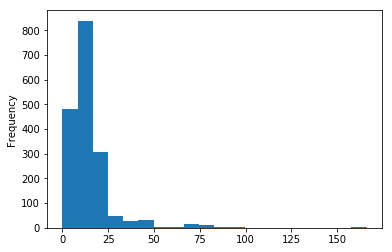

'firebird',


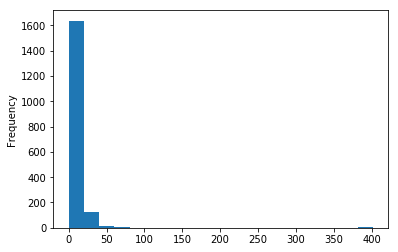

'monetdb',


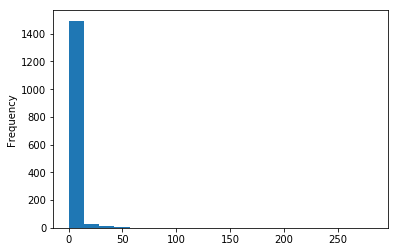

'mssql',


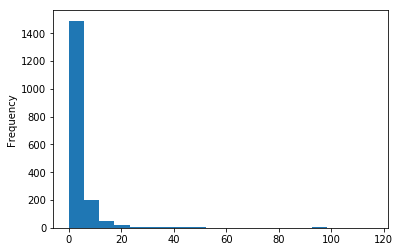

'mysql',


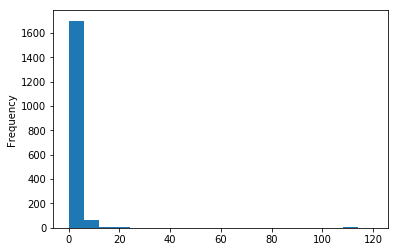

'oracle',


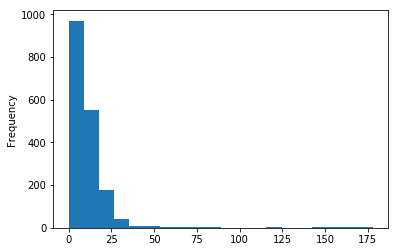

'pgsql',


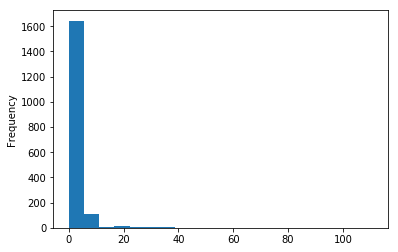

'sqltm',


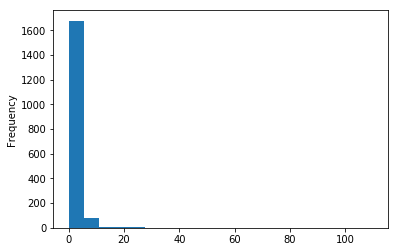

'teradata',


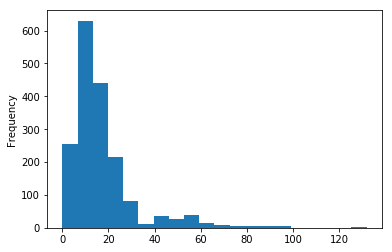

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.est_dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
